In [ ]:
# Does some simple analysis of simulated images written out by the sim notebook.

In [1]:
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS

import scipy
import glob
import os

from matplotlib import pyplot as plt
from matplotlib import colors

In [ ]:
# the files for finding the FOV (dithered PSFs)
file_names_fov = glob.glob('./fits/*.fits')

# the files for finding the plate scale (grid mask)
file_name_grid = glob.glob('./fits/*.fits')

# the files for constraining stray light (pinhole)
file_name_pinhole = glob.glob('./fits/*.fits')


In [10]:
print(file_list)

['./fits/IMG_OPT_02_wcu_focal_plane_grid_lm.fits', './fits/IMG_OPT_02_wcu_focal_plane_grid_lm_LM.fits', './fits/IMG_OPT_02_wcu_focal_plane_grid_lm_LM_blur.fits', './fits/IMG_OPT_02_wcu_focal_plane_open.fits', './fits/IMG_OPT_02_wcu_focal_plane_open_LM.fits', './fits/IMG_OPT_02_wcu_focal_plane_open_LM_blur.fits', './fits/IMG_OPT_02_wcu_focal_plane_pinhole_lm.fits', './fits/IMG_OPT_02_wcu_focal_plane_pinhole_lm_LM.fits', './fits/IMG_OPT_02_wcu_focal_plane_pinhole_lm_LM_blur.fits', './fits/IMG_OPT_02_wcu_focal_plane_pinhole_n.fits', './fits/IMG_OPT_02_wcu_focal_plane_pinhole_n_LM.fits', './fits/IMG_OPT_02_wcu_focal_plane_pinhole_n_LM_blur.fits']


In [25]:
#test = fits.util.get_testdata_filepath('./fits/IMG_OPT_02_wcu_focal_plane_grid_lm.fits')
orig_data = fits.open('/playing_with_scopesim/fits/IMG_OPT_02_wcu_focal_plane_pinhole_lm_LM.fits')
#orig_data = orig_data[0].data

In [21]:
import os
print(os.getcwd())

/playing_with_scopesim


In [27]:
print(orig_data[1].data)

[[20441.73  20194.967 20468.264 ... 21422.584 21875.285 22761.176]
 [20201.002 20305.64  21088.164 ... 22269.61  22757.098 23321.057]
 [20426.96  20990.98  22126.55  ... 23535.42  23723.271 24046.67 ]
 ...
 [21388.076 22226.988 23509.1   ... 24869.639 24945.664 24935.428]
 [21934.078 22671.287 23740.873 ... 24888.736 24978.383 24940.914]
 [22734.096 23226.193 24058.494 ... 24906.879 24916.37  24872.693]]


In [30]:
def fft_array(data_file_name, pix_scale=8.2e-3, fill_nans=False):
    # Inputs:
    # data_file_name: path name to file
    # pix_scale: plate scale (arcsec/pix)
    # fill_nans: fill nans in the input data?
    
    # Take the FFT of the input data and return 

    # INPUTS:
    #   data_file_name: str, path to the input data file
    #   pix_scale: float, pixel scale in asec/pix

    # OUTPUTS:
    #   amp_fft_data: np.ndarray, amplitude of the FFT
    #   arg_fft_data: np.ndarray, phase of the FFT

    # [ complex aperture ]  <---autocorrel--->  [ OTF ]
    #          |                                    |
    #          FT                                   FT
    #          |                                    |
    #        [ A ]          <---|  |^2----->    [ PSF ]
    #
    #  N.b.: [ A ] is the complex field AT THE FOCAL PLANE (modulo a quadratic phase factor; 
    # see Tyson, sec. 4.2.1, 'Principles and Applications of Fourier Optics')

    # read in FITS file
    orig_data = fits.open(data_file_name)
    orig_data = orig_data[1].data

    if fill_nans:
        orig_data = np.nan_to_num(orig_data, nan=np.nanmedian(orig_data), posinf=np.nanmedian(orig_data), neginf=np.nanmedian(orig_data))
        print('Filled NaNs with median value')

    # Calculate spatial frequency scale
    ny, nx = orig_data.shape
    freq_scale = 1.0 / (nx * pix_scale)  # cycles per arcsecond per pixel

    # Create spatial extent for original data
    data_extent = [-nx/2 * pix_scale, nx/2 * pix_scale,
                -ny/2 * pix_scale, ny/2 * pix_scale]

    # Create spatial frequency arrays for plotting
    fft_y_freq = np.fft.fftshift(np.fft.fftfreq(ny)) * ny * freq_scale
    fft_x_freq = np.fft.fftshift(np.fft.fftfreq(nx)) * nx * freq_scale
    fft_extent = [fft_x_freq[0], fft_x_freq[-1], fft_y_freq[0], fft_y_freq[-1]]

    # centering to avoid checkerboard pattern
    # (best to have an input array with odd-numbered dimension lengths)
    data = np.fft.ifftshift(orig_data)

    FFT_data = np.fft.fftshift(np.fft.fft2(data))  # one shift, after FFT

    amp_fft_data = np.abs(FFT_data)            # no second shift
    arg_fft_data = np.angle(FFT_data)  

    # return the complex field at focal plane [ A ], and the resulting PSF intensity [ PSF ], OTF amplitude, OTF argument
    return orig_data, amp_fft_data, arg_fft_data, data_extent, fft_x_freq, fft_y_freq, fft_extent

In [3]:
dir_sim_data = './fits/'

In [4]:
test = glob.glob(dir_sim_data + '*fits')

In [5]:
test

['./fits/IMG_OPT_02_wcu_focal_plane_grid_lm.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_grid_lm_LM.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_grid_lm_LM_blur.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_open.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_open_LM.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_open_LM_blur.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_pinhole_lm.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_pinhole_lm_LM.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_pinhole_lm_LM_blur.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_pinhole_n.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_pinhole_n_LM.fits',
 './fits/IMG_OPT_02_wcu_focal_plane_pinhole_n_LM_blur.fits']

### Req. METIS-1408: Quality and alignment of the optical components within Mid-infrared ELT Imager and Spectrograph (METIS) shall provide diffraction limited performance (Strehl ≥ 80 %) at λ > 3μm in all modes over the entire FOV.

In [3]:
image_theory = fits.open('./fits/IMG_OPT_02_wcu_focal_plane_pinhole_lm_LM.fits')
image_empirical = fits.open('./fits/IMG_OPT_02_wcu_focal_plane_pinhole_lm_LM_blur.fits')

In [29]:
image_theory.info()

Filename: ./fits/IMG_OPT_02_wcu_focal_plane_pinhole_lm_LM.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      82   ()      
  1  DET1.DATA     1 ImageHDU        50   (2048, 2048)   float32   


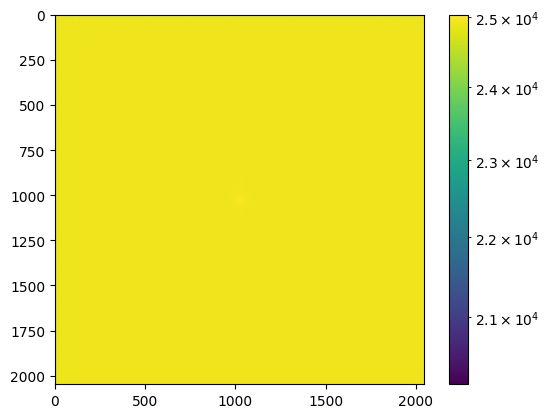

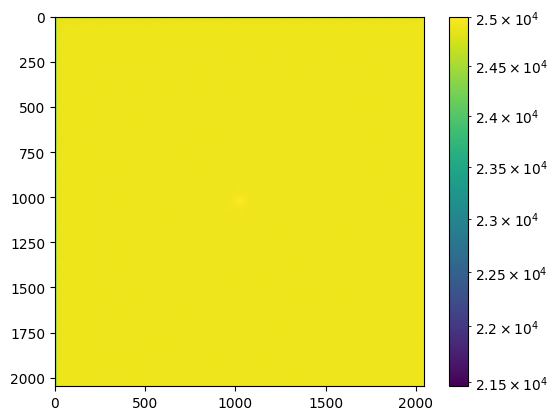

In [30]:
plt.imshow(image_theory[1].data, norm='log')
plt.colorbar()
plt.show()

plt.imshow(image_empirical[1].data, norm='log')
plt.colorbar()
plt.show()

In [36]:
# get the MTFs

# orig_data, amp_fft_data, arg_fft_data, data_extent, fft_x_freq, fft_y_freq, fft_extent
mtf_perfect = fft_array(data_file_name = './fits/IMG_OPT_02_wcu_focal_plane_grid_lm_LM.fits')
mtf_empirical = fft_array(data_file_name = './fits/IMG_OPT_02_wcu_focal_plane_grid_lm_LM_blur.fits')

In [44]:
mtf_empirical[1]

array([[11.29492188, 10.82818742, 10.38960592, ..., 10.32573208,
        10.38960592, 10.82818742],
       [ 9.8793267 ,  9.91886928,  9.60305517, ..., 10.73977172,
        10.25366271, 10.81214421],
       [11.73084723, 10.35300315, 10.99814355, ..., 11.19220089,
        10.40260827,  7.83308391],
       ...,
       [ 9.74395053, 10.06045998, 10.04928153, ...,  9.57607285,
         9.518094  , 10.84712251],
       [11.73084723,  7.83308391, 10.40260827, ..., 12.25618313,
        10.99814355, 10.35300315],
       [ 9.8793267 , 10.81214421, 10.25366271, ..., 10.15947978,
         9.60305517,  9.91886928]])

138378734605.7389
419084454322.8973
Strehl: 0.3301929555686179


TypeError: Invalid shape () for image data

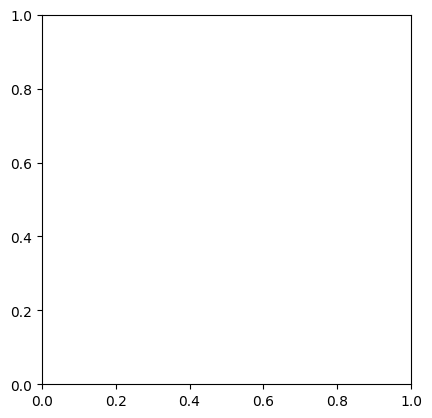

In [48]:
mtf_empirical_sum = np.nansum(mtf_empirical[1])
mtf_perfect_sum = np.nansum(mtf_perfect[1])

print(mtf_empirical_sum)
print(mtf_perfect_sum)

print(f'Strehl: {mtf_empirical_sum/mtf_perfect_sum}')

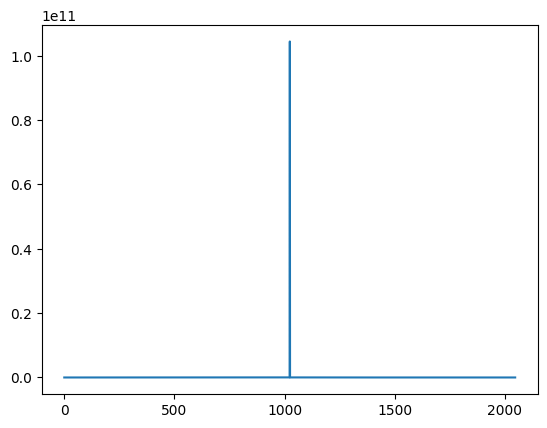

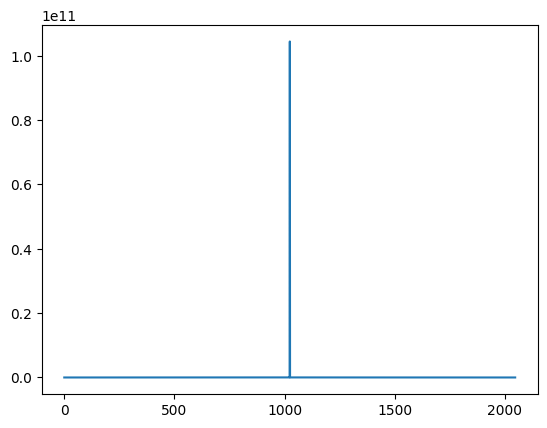

In [40]:
plt.clf()
plt.plot(mtf_empirical[1][1024])
plt.show()

plt.clf()
plt.plot(mtf_perfect[1][1024])
plt.show()

In [14]:
test[1].data

array([[20441.73 , 20194.967, 20468.264, ..., 21422.584, 21875.285,
        22761.176],
       [20201.002, 20305.64 , 21088.164, ..., 22269.61 , 22757.098,
        23321.057],
       [20426.96 , 20990.98 , 22126.55 , ..., 23535.42 , 23723.271,
        24046.67 ],
       ...,
       [21388.076, 22226.988, 23509.1  , ..., 24869.639, 24945.664,
        24935.428],
       [21934.078, 22671.287, 23740.873, ..., 24888.736, 24978.383,
        24940.914],
       [22734.096, 23226.193, 24058.494, ..., 24906.879, 24916.37 ,
        24872.693]], dtype='>f4')